# <center> Regresión Lineal</center>
Se utiliza para estimar los valores reales (costo de las viviendas, el número de llamadas, ventas totales, etc.) basados en variables continuas. La idea es tratar de establecer la relación entre las variables independientes y dependientes por medio de ajustar una mejor línea recta con respecto a los puntos. Esta línea de mejor ajuste se conoce como línea de regresión y esta representada por la siguiente ecuación lineal:
<center>$y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n$</center>

## Pisos en alquiler en Jerez de la Frontera
Vamos a implementar un ejemplo real de aplicación de una regresión lineal para un conjunto de viviendas en alquiler.

### Recolección de información


In [1]:
from bs4 import BeautifulSoup
from requests import get

provider = "https://www.idealista.com"

# Pisos más baratos en alquiler por precio en orden ascendente en Jerez de la Frontera
url = provider + "/alquiler-viviendas/jerez-de-la-frontera-cadiz/pagina-{0}.htm?ordenado-por=precio-asc"

def get_page_content(url):
    soup = BeautifulSoup(get(url).content, "html.parser")
    containers = soup.find_all(class_="item-info-container")
    pisos = []
    for i, container in enumerate(containers):
        piso_info = {}
        if i > 0:
            piso_info["href"] = provider + container.find(class_="item-link")["href"]
            piso_info["nombre"] = container.find(class_="item-link").string
            try:  # Estos pisos no declaran los datos correctamente
                piso_info["precio"] = int(container.find(class_="item-price").contents[0])
                detalles = container.find_all(class_="item-detail")
                piso_info["habitaciones"] = int(detalles[0].contents[0])
                piso_info["metros"] = int(detalles[1].contents[0])
            except ValueError: # los ignoramos
                continue
            pisos.append(piso_info)
    return pisos

pisos = []
pagination = list(range(1, 10))
for page in pagination:
    page = url.format(page)
    pisos += get_page_content(page)


### Exploración de los datos
Convertimos los datos en un DataFrame de pandas y observamos algunas variables estadísticas:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Obtenemos los pisos en pandas eliminando duplicados
df = pd.DataFrame(pisos).drop_duplicates()

print(len(df))  # Número de pisos en la muestra
df.describe()

186


,habitaciones,metros,precio
count,186.000000,186.000000,186.000000
mean,2.516129,97.053763,538.569892
std,1.081669,44.174926,162.324759
min,1.000000,28.000000,180.000000
25%,2.000000,67.250000,400.000000
50%,3.000000,90.000000,500.000000
75%,3.000000,120.000000,650.000000
max,5.000000,350.000000,995.000000


Dibujamos las distribuciones de metros$^2$ y del precio. La línea continua representa la media y la discontinua la mediana.

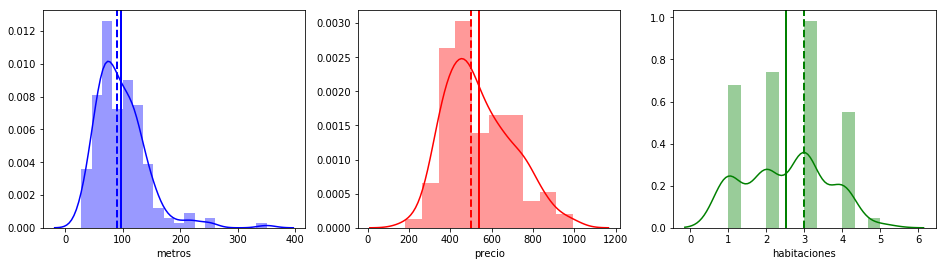

In [3]:
colores = ["blue", "red", "green"]

fig, ax = plt.subplots(figsize=(16, 4))

features = ["metros", "precio", "habitaciones"]

for i, var in enumerate(features):
    plt.subplot(131 + i)  # Cambiamos de subplot
    sns.distplot(df[var], color=colores[i])  # Histograma con seaborn
    plt.axvline(df[var].mean(), color=colores[i], linestyle="solid", linewidth=2)
    plt.axvline(df[var].median(), color=colores[i], linestyle="dashed", linewidth=2)

plt.show()

Dibujamos la relación entre metros cuadrados y precios.

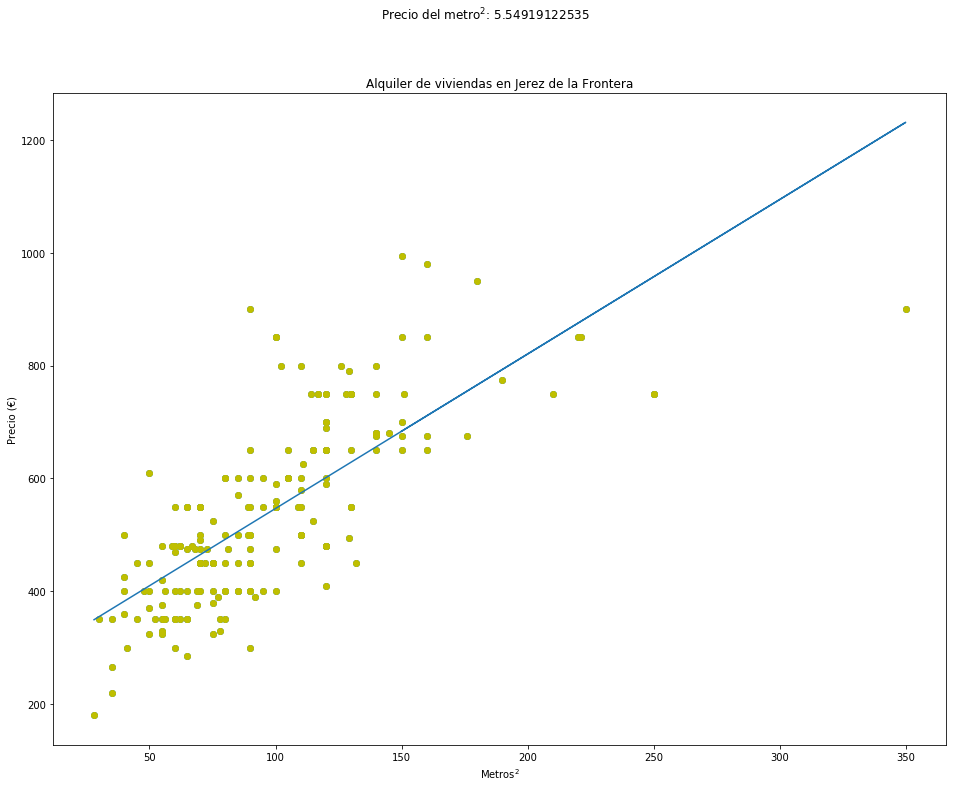

In [4]:
fig, ax = plt.subplots(figsize=(16, 12))
x = df["metros"]
y = df["precio"]

# Obtenemos el precio medio del metro cuadrado
precio_metro2 = np.mean(df["precio"]) / np.mean(df["metros"])

ax.scatter(x, y)
ax.set_title("Alquiler de viviendas en Jerez de la Frontera")
plt.suptitle("Precio del metro$^2$: %s" % str(precio_metro2))
ax.set_xlabel("Metros$^2$")
ax.set_ylabel("Precio (€)")

# Dibujamos la línea de regresión lineal
# https://stackoverflow.com/questions/6148207/linear-regression-with-matplotlib-numpy
# http://www.emilkhatib.es/encontrando-tendencias-con-pandas/
fit = np.polyfit(x,y,1)
fit_fn = np.poly1d(fit)
#print(fit_fn)  # Nos devuelve una función lineal
plt.plot(x,y, 'yo', x, fit_fn(x), label=str(fit_fn))

plt.show()

Creamos un modelo de aprendizaje que tiene en cuenta el número de habitaciones y los metros$^2$ de cada piso.

In [5]:
from sklearn import model_selection, linear_model

X = df.drop(["href", "nombre", "precio"], axis=1)
Y = df["precio"]  # Precio de las casas

# Separamos los datos de entrenamiento de los de testeo
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(
    X, Y, 
    test_size=0.33,
    random_state = 5
)


lm = linear_model.LinearRegression()  # Creamos el modelo
lm.fit(X_train, Y_train) # Lo ajustamos

# Predecimos los valores
pred = lm.predict(X_test)
# Comparación de predicciones y valores observados
df_pred = pd.DataFrame({"Verdadera": Y_test, "Predicción": pred})
print(df_pred.head())

# Error cuadrático medio (mean square error)
MSE = np.mean(pred - Y_test) **2
print("\nMSE: {:2}".format(MSE))

     Predicción  Verdadera
25   379.082559        360
6    406.858851        300
150  675.811525        680
102  582.035205        550
101  609.811498        550

MSE: 208.047999160755


______________________________________________

## Implementación Boston 

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets, model_selection, linear_model

# Ruta a la carpeta de datos
import os
data_folder = os.path.join(os.path.dirname(os.getcwd()), "datos")

#### Recolección de datos
El siguiente ejemplo utiliza un conjunto de datos de los precios de las casas en Boston comparados con diferentes características. El dataset viene incluido entre los datasets de `sklearn`, pero en la vida real no encontraremos datasets tan bien pulidos, motivo por el cual lo he descargado a parte.

El dataset Boston es un conjunto de datos recogidos en 1978, por lo que no te extrañes encontrar precios de casas tan bajos (multiplicalo por 35 para aproximarte a los ratios de inflación actuales).

In [7]:
# Cargamos el dataset de los precios de viviendas en Boston
boston_dataset_file = os.path.join(data_folder, "precios_viviendas_boston.csv")
boston_df = pd.read_csv(boston_dataset_file)

# Limpiamos los datos
del boston_df["Unnamed: 0"] # Trae doble índice

# Consultamos algunas características del dataset (descomentar)
#print(boston_df.shape)  # 506, 14  (Filas, columnas)
#print(boston_df.columns)  # Nombres de los aributos (columnas)

# Si queremos ver la descripción de los atributos, sklearn los trae incorporados:
boston = datasets.load_boston()
#print(boston["DESCR"])  # Descomentar

# sklearn no inlcuye el atributo medv en los valores, el cual indica el precio,
# si no que lo inluye en target (boston.target)

boston_df.head()  # Mostramos la estructura del conjunto de datos

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


#### Exploración de datos

Para familiarizarnos con el dataset, calculamos algunas estadísticas descriptivas (ver [Introducción a la estadística descriptiva](https://github.com/mondeja/fullstack/tree/master/backend/src/001-matematicas/teoria_practica/estadistica/descriptiva.ipynb)):

In [8]:
# Los multiplicamos por 1000, ya que los preios vienen en miles de dólares
precios = boston_df["medv"] * 1000

precio_min = np.min(precios)
precio_max = np.max(precios)
precio_medio = np.mean(precios)
precio_mediano = np.median(precios)
desviacion_estandar = np.std(precios)

print("Precio mínimo: %d $" % precio_min)
print("Precio máximo: %d $" % precio_max)
print("Precio medio: %d $" % precio_medio)
print("Precio mediano: %d $" % precio_mediano)
print("Desviación estándar: %d $" % desviacion_estandar)

Precio mínimo: 5000 $
Precio máximo: 50000 $
Precio medio: 22532 $
Precio mediano: 21200 $
Desviación estándar: 9188 $


Dibujamos como están distribuidas las variables (ver [Histogramas y distribuciones](https://github.com/mondeja/fullstack/tree/master/backend/src/001-matematicas/teoria_practica/estadistica/histogramas_distribuciones.ipynb)). La línea vertical solida representa la media y la discontinua la mediana:

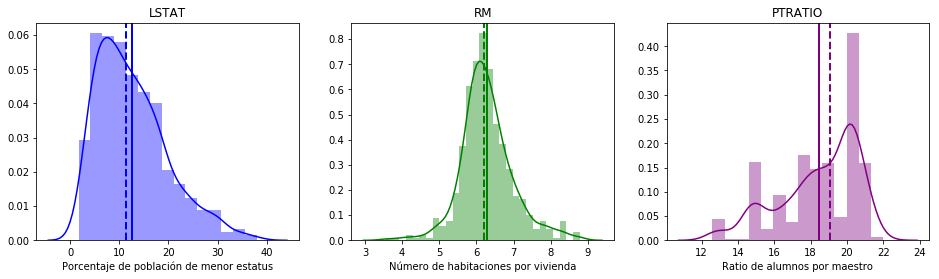

In [9]:
# Colores para cada distribución
colores = ["blue", "green", "purple"]

# Variables usadas y descripciones de las mismas
var_desc = {
    "rm": "Número de habitaciones por vivienda",
    "lstat": "Porcentaje de población de menor estatus",
    "ptratio": "Ratio de alumnos por maestro"
}

fig, ax = plt.subplots(figsize=(16, 4))

for i, (var, desc) in enumerate(var_desc.items()):
    plt.subplot(131 + i)  # Cambiamos de subplot
    sns.distplot(boston_df[var], color=colores[i])  # Histograma con seaborn
    plt.axvline(boston_df[var].mean(), color=colores[i], linestyle="solid", linewidth=2)
    plt.axvline(boston_df[var].median(), color=colores[i], linestyle="dashed", linewidth=2)
    plt.xlabel(desc)
    plt.title(var.upper())

plt.show()


La función [`distplot()`](https://seaborn.pydata.org/generated/seaborn.distplot.html) de `seaborn` facilita la representación de distribuciones estadísticas.

También podemos compararlos con el precio de las casas por medio de un gráfico de puntos.

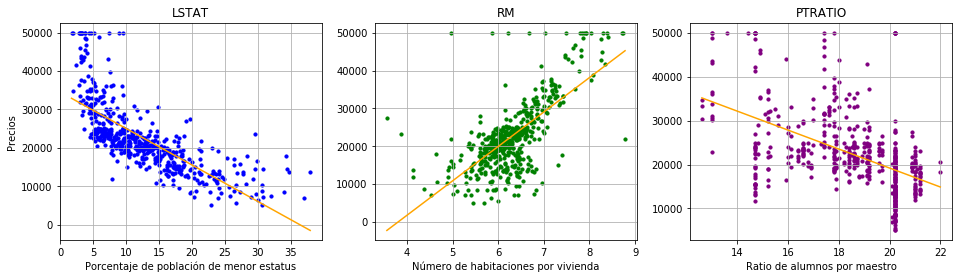

In [10]:
fig, axs = plt.subplots(ncols=3, figsize=(16, 4), sharex=True)

for i, (var, desc) in enumerate(var_desc.items()):
    x = boston_df[var]
    y = precios
    plt.subplot(131 + i)
    plt.scatter(x, y, c=colores[i], s=10) # c=color, s=tamaño_de_puntos
    
    # Creamos línea de regresión
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), c="orange")

    plt.grid(True)
    plt.title(var.upper())
    plt.xlabel(desc)
    if i == 0: 
        plt.ylabel("Precios")

plt.show()

#### Entrenamiento
Primero debemos dividir el dataset en dos: los precios de las casas y los valores de predicción. Podrías divir el dataset de forma manual, pero esa no sería la forma correcta de hacerlo. Con la función `train_test_split()` del submódulo de sklearn `model_selection` podemos dividir el dataset de una forma más controlada:

In [11]:
# Eliminamos la columna del precio de los valores de predicción
X = boston_df.drop("medv", axis=1)
Y = boston_df["medv"]  # Precio de las casas

# Separamos los datos de entrenamiento de los de testeo
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(
    X, Y, 
    test_size=0.33, 
    random_state = 5
)


# Obtenemos el modelo de Regresión Lineal de sklearn
lm = linear_model.LinearRegression()  # Creamos el modelo
lm.fit(X_train, Y_train) # Lo ajustamos

# Predecimos los valores
pred = lm.predict(X_test)
# Comparación de predicciones y valores observados
df_pred = pd.DataFrame({"Valor": Y_test, "Predicción": pred})
df_pred.head()

# Error cuadrático medio (mean square error)
MSE = np.mean(pred - Y_test) **2
print(MSE)

0.457367490998


Fuentes:
- https://olegleyz.github.io/boston_housing.html
- http://www.neural.cz/dataset-exploration-boston-house-pricing.html
- http://www.ritchieng.com/machine-learning-project-boston-home-prices/